# KNN

This notebook uses a **K-Nearest Neighbors** classifier, a generative model, to solve the classification task of digits labeling.

## Packages import

In [1]:
from sklearn.model_selection import train_test_split

from assignment_2.digits_classifiers.model import Dataset, ClassifierTuning
from assignment_2.digits_classifiers.classifiers import KNN
from assignment_2.digits_classifiers.io import read_datasets

## Import dataset

Reading [MNIST handwritten digits](https://yann.lecun.com/exdb/mnist/) dataset.

In [2]:
data = read_datasets()

2022-12-26 15:21:49.808 | INFO     | assignment_2.digits_classifiers.io:read_datasets:46 - Reading datasets


In [3]:
X, y = data

## Removing constant columns

Removing constant-zero features.

In [4]:
X.shape

(70000, 784)

There are 65 pixels with constant value 0.

In [5]:
always_zero = [c for c in list(X.columns) if sum(X.loc[:, c]) == 0]
len(always_zero)

65

In [6]:
X.drop(columns=always_zero, axis=1, inplace=True)
X.shape

(70000, 719)

## Train Test split

Splitting train and test set with **proportion 4:1**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

Combining feature space and labels

In [8]:
train = Dataset(x=X_train, y=y_train)
test = Dataset(x=X_test, y=y_test)

Digit distribution in the training set:

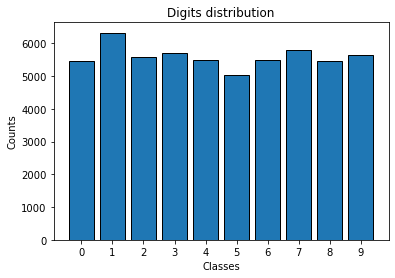

In [9]:
train.digit_distribution()

## Experimental Evaluation

### Validation Phase

Generating classifiers with candidate hyperparameters

In [10]:
knns = [
    KNN(train=train, test=test, params={"k": k})
    for k in [5, 11, 29]
]
knns

[[KNN: Train 56000, Test 14000, not fitted, not predicted] [k: 5],
 [KNN: Train 56000, Test 14000, not fitted, not predicted] [k: 11],
 [KNN: Train 56000, Test 14000, not fitted, not predicted] [k: 29]]

Restricting Train set cardinality for validation phase to 20%

In [11]:
_, X_train_cv, _, y_train_cv = train_test_split(X_train, y_train, test_size=0.20)
train_cv = Dataset(x=X_train_cv, y=y_train_cv)

In [12]:
X_train_cv.shape

(11200, 719)

Generating tuning class

In [14]:
tuning_knns = ClassifierTuning(classifiers=knns, base_estimator=KNN.default_estimator(), data=train_cv, k=5)
tuning_knns

[Estimator: KNNEstimator(); K: 5; Params: {'k': [29, 11, 5]}]

Evaluating 5-fold Cross-Validation

In [15]:
%%time
tuning_knns.evaluate()

Wall time: 22min 16s


Select model with 5 neighbors:

In [16]:
tuning_knns.best_params

{'k': 5}

Accuracy of the selected model:

In [17]:
tuning_knns.best_score

0.9475892857142856

### Training phase

Generating the model with tuned hyperparameters

In [18]:
best_knn = KNN(train=train, test=test, params=tuning_knns.best_params)
best_knn

[KNN: Train 56000, Test 14000, not fitted, not predicted] [k: 5]

Training the model

In [19]:
%%time
best_knn.train()

Wall time: 469 ms


### Predicting phase

Evaluating predictions

In [20]:
%%time
best_knn.predict()

Wall time: 1h 56min 58s


Accuracy on Test set:

In [21]:
best_knn.accuracy

0.9713571428571428

Plot confusion matrix:

2022-12-24 04:47:01.133 | INFO     | assignment_2.digits_classifiers.model:confusion_matrix:197 - Saving C:\Users\user\Documents\GitHub\AI_assignments\assignment_2\digits_classifiers\images\knn_cm.png


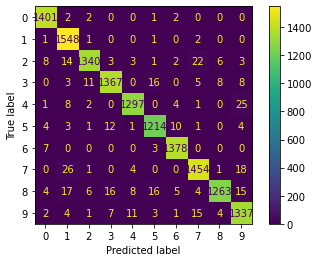

In [22]:
best_knn.confusion_matrix(save=True, file_name='knn_cm.png')

### Fool data

Behaviour on fool data

In [25]:
from assignment_2.digits_classifiers.io import read_fool_dataset

X_fool = read_fool_dataset()
X_fool.drop(columns=always_zero, axis=1, inplace=True)

In [26]:
best_knn.estimator.predict(X=X_fool)

array([9, 3, 9, 5, 1, 0])